# Hyrax SL Challenge Demo
This notebook demonstrates how Hyrax can be used to develop models for [Strong Lensing Challenge](https://slchallenge.cbpf.br/_).

Prerequisites for this notebook
1) `pip install hyrax`
2) Downloading and preparing a smaller dataset. (The following notebooks provides helpful code for doing exactly that.)
   1) https://github.com/lincc-frameworks/notebooks_lf/blob/main/make_small_sl_dataset.ipynb
3) Providing feedback to the Hyrax development team if you run into difficulty :)

In [ ]:
# Create a Hyrax instance
from hyrax import Hyrax
h = Hyrax()

[2025-09-02 14:18:31,322 hyrax:INFO] Runtime Config read from: /Users/drew/code/hyrax/src/hyrax/hyrax_default_config.toml


In [15]:
# Tell Hyrax were to look for the data it will use
h.config["general"]["data_dir"] = "/Users/drew/sl_data_challenge/sl_100/slsim_combined"
# h.config["general"]["data_dir"] = "/home/drew/data/sl_100/slsim_combined"

## Create a custom dataset for SL Challenge data
A Hyrax dataset is a piece of code that knows how to retrieve data that is stored on disk when it is requested by the machine learning framework.
In this case, the following `SLDataset` class knows that each object in the dataset has 5 associated files corresponding to 5 filter bands.
When the ML framework requests data (by providing an integer index) `SLDataset` knows which files to open and concatenate together into a PyTorch tensor.

See the comments in the following class for a few more details.

In [29]:
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset
from torch import from_numpy
from hyrax.data_sets import HyraxDataset
from astropy.io import fits
from astropy.table import Table
from collections.abc import Generator


"""
Note - `index` this class refers to the object index in the directory when all
the files are sorted alphabetically.
"""


class SLDataset(HyraxDataset, Dataset):
    def __init__(self, config: dict):
        super().__init__(config)
        self.data_directory = Path(config["general"]["data_dir"])
        self.metadata = self.read_metadata(self.data_directory)
        self.filepaths = self.read_filepaths(self.data_directory)
        self.object_id_cache = {}

    def read_metadata(self, data_directory: Path):
        """Read metadata from the `parameters.fits` file.

        Parameters
        ----------
        data_directory : Path
            The directory containing the FITS files.

        Returns
        -------
        Table
            The metadata table.
        """
        table = Table.read(data_directory / "parameters.fits")
        table["object_id"] = np.where(table["Lens ID"].mask, table["Object ID"], table["Lens ID"])
        return table

    def read_filepaths(self, data_directory: Path):
        """Read the file paths of the FITS files in the data directory.

        Parameters
        ----------
        data_directory : Path
            The directory containing the FITS files.

        Returns
        -------
        list[Path]
            A sorted list of paths to the FITS files.
        """
        return sorted(list(data_directory.glob("*_*.fits")))

    def get_image(self, index: int):
        """This function retrieves the image data for a given object index.

        Parameters
        ----------
        index : int
            The object index.

        Returns
        -------
        PyTorch tensor
            The image data for the given object index.
        """
        image_stack = np.zeros((5, 41, 41), dtype=np.float32)
        for b in range(5):
            file_index = index * 5 + b
            raw_data = fits.getdata(self.filepaths[file_index], memmap=False)
            image_stack[b] = raw_data[0][1]

        self.object_id_cache[index] = str(raw_data[0][0])
        return from_numpy(image_stack)

    def get_label(self, index: int) -> np.ndarray[int]:
        """This function generates a label for the given object. Since there are
        only two classes (lens and non-lens), we can use a simple binary encoding.

        Here a return of [1, 0] indicates a lens, while [0, 1] indicates a non-lens.

        Parameters
        ----------
        index : int
            The object index

        Returns
        -------
        np.ndarray[int]
            [1, 0] = lens, [0, 1] = non-lens
        """
        file_index = index * 5
        ret_value = np.array([0.0, 1.0], dtype=np.float32)
        if "_L_" in str(self.filepaths[file_index]):
            ret_value = np.array([1.0, 0.0], dtype=np.float32)
        return from_numpy(ret_value)

    def get_object_id(self, index: int) -> str:
        """Retrieve the object ID for a given object index from the cache or the
        FITS file.

        Note: In Hyrax, object identifiers are _always_ strings.

        Parameters
        ----------
        index : int
            The object index

        Returns
        -------
        str
            The object ID for the given index
        """
        if index not in self.object_id_cache:
            # If there is a cache miss, add the object ID to the cache
            file_index = index * 5
            raw_data = fits.getdata(self.filepaths[file_index], memmap=False)
            self.object_id_cache[index] = str(raw_data[0][0])

        return self.object_id_cache[index]

    def get_filename(self, index: int) -> str:
        file_index = index * 5
        return str(self.filepaths[file_index].name)

    def metadata_fields(self):
        """Helper function that returns the metadata field names for visualization."""
        return self.metadata.columns

    def ids(self) -> Generator[str]:
        """Helper function that returns the object IDs for all objects."""
        for x in range(len(self)):
            yield str(self.get_object_id(x))

    def __len__(self):
        """Return the number of objects in the dataset.

        Returns
        -------
        int
            The number of objects.
        """
        return len(self.filepaths) // 5

    def __getitem__(self, index: int):
        """Retrieve an item from the dataset.

        Parameters
        ----------
        index : int
            The index of the item to retrieve.

        Returns
        -------
        dict
            A dictionary containing the image, label, and object ID.
        """
        return {
            "image": self.get_image(index),
            "label": self.get_label(index),  # [1, 0] == lens, [0, 1] == non-lens
            "object_id": self.get_object_id(index),
        }

## Prep and examine some sample data
Now that we have the `SLDataset` class defined, we can create an instance of it, and explore the data a bit

In [16]:
h.config["data_set"]["name"] = "SLDataset"
ds = h.prepare()

[2025-09-02 14:57:10,939 hyrax.prepare:INFO] Finished Prepare


In [17]:
samp = ds[5]
print(f"ID: {samp['object_id']}")
print(f"Is lens? {samp['label']}")
print(f"Data shape: {samp['image'].shape}")


samp = ds[105]
print(f"ID: {samp['object_id']}")
print(f"Is lens? {samp['label']}")
print(f"Data shape: {samp['image'].shape}")

ID: GG-LENS_-0.0199_-0.0174
Is lens? tensor([1., 0.])
Data shape: torch.Size([5, 41, 41])
ID: GG-LENS_0.0328_-0.0317
Is lens? tensor([0., 1.])
Data shape: torch.Size([5, 41, 41])


## Update configs for training
As a first attempt, we'll use the built in `HyraxCNN` to see if we can classify our data.
We'll update a few of the parameters, including the number of output classes from the model and the number of epochs for training.
Then we'll train the model.

In [18]:
h.config["model"]["name"] = "HyraxCNN"
h.config["model"]["hyrax_cnn"]["output_classes"] = 2
h.config["train"]["epochs"] = 30
h.config["data_loader"]["batch_size"] = 10

In [19]:
h.train()

[2025-09-02 14:59:07,135 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-09-02 14:59:07,136 hyrax.models.model_registry:INFO] Using optimizer: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
2025-09-02 14:59:07,139 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x33af73f80>, 'batch_size': 10, 'shuffle': False, 'pin_memory': False}
2025-09-02 14:59:07,140 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x33afd8800>, 'batch_size': 10, 'shuffle': False, 'pin_memory': False}
2025/09/02 14:59:07 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/09/02 14:59:07 INFO mlflow.system_metrics.system_me

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

[2025-09-02 14:59:34,949 hyrax.pytorch_ignite:INFO] Total training time: 27.71[s]
[2025-09-02 14:59:34,950 hyrax.pytorch_ignite:INFO] Latest checkpoint saved as: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-145907-train-W04B/checkpoint_epoch_30.pt
[2025-09-02 14:59:34,951 hyrax.pytorch_ignite:INFO] Best metric checkpoint saved as: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-145907-train-W04B/checkpoint_30_loss=-0.0418.pt
2025/09/02 14:59:34 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/02 14:59:34 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-09-02 14:59:34,961 hyrax.verbs.train:INFO] Finished Training
[2025-09-02 14:59:35,076 hyrax.model_exporters:INFO] Exported model to ONNX format: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-145907-train-W04B/example_model_opset_20.onnx


HyraxCNN(
  (conv1): Conv2d(5, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (criterion): CrossEntropyLoss()
)

After training we can run inference, and then (if you scroll past the boilerplate code) you can see that this time, the model performed about as well as a coin flip.

In [20]:
h.infer()

[2025-09-02 15:05:15,445 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-09-02 15:05:15,454 hyrax.models.model_registry:INFO] Using optimizer: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
[2025-09-02 15:05:15,454 hyrax.verbs.infer:INFO] data set has length 200
2025-09-02 15:05:15,455 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': None, 'batch_size': 10, 'shuffle': False, 'pin_memory': False}
[2025-09-02 15:05:15,461 hyrax.verbs.infer:INFO] Saving inference results at: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150515-infer-CTt_
[2025-09-02 15:05:15,810 hyrax.pytorch_ignite:INFO] Evaluating model on device: mps
[2025-09-02 15:05:15,811 hyrax.pytorch_ignite:INFO] Total epochs: 1


  5%|5         | 1/20 [00:00<?, ?it/s]

[2025-09-02 15:05:16,987 hyrax.pytorch_ignite:INFO] Total evaluation time: 1.18[s]
[2025-09-02 15:05:17,012 hyrax.verbs.infer:INFO] Inference Complete.


## Boilerplate code to generate the confusion matrix from the results of inference

In [21]:
from hyrax.data_sets import InferenceDataSet
from hyrax.config_utils import find_most_recent_results_dir
import torch

infer_dir = find_most_recent_results_dir(h.config, "infer")
infer_ds = InferenceDataSet(h.config, infer_dir)

lens_count = 0
nonlens_count = 0
confusion_matrix = np.zeros((2, 2))
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for indx, id in enumerate(infer_ds.ids()):
    _, predicted = torch.max(infer_ds[indx], 0)
    if predicted == 0:
        lens_count += 1
    else:
        nonlens_count += 1

    orig_data = ds[indx]
    label = orig_data['label']
    
    # original object is lense
    if label[0] == 1.0:
        if predicted == 0: # predict lense true positive
            confusion_matrix[0][0] += 1
            true_pos += 1
        else: # predict non-lense - false negative
            confusion_matrix[0][1] += 1
            false_neg += 1

    # original object is non-lense
    elif label[0] == 0.0:
        if predicted == 0: # predict lense false positive
            confusion_matrix[1][0] += 1
            false_pos += 1
        else: # predict non-lense true negative
            confusion_matrix[1][1] += 1
            true_neg += 1

print(f"Total Lens: {lens_count}, Total Non-Lens: {nonlens_count}")
print(f"True Positives: {true_pos}, True Negatives: {true_neg}, False Positives: {false_pos}, False Negatives: {false_neg}")
print(f"Confusion matrix: {confusion_matrix}")

Total Lens: 105, Total Non-Lens: 95
True Positives: 54, True Negatives: 49, False Positives: 51, False Negatives: 46
Confusion matrix: [[54. 46.]
 [51. 49.]]


In [22]:
import matplotlib.pyplot as plt
import matplotlib
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=-30, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


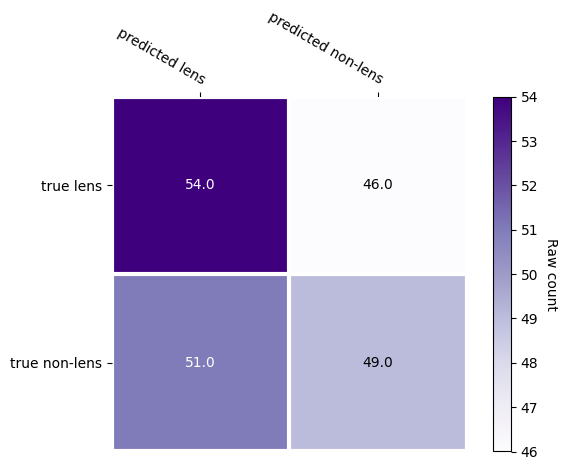

In [23]:

fig, ax = plt.subplots()
original_labels = ['true lens', 'true non-lens']
predicted_labels = ['predicted lens', 'predicted non-lens']

im, cbar = heatmap(confusion_matrix, original_labels, predicted_labels, ax=ax,
                   cmap="Purples", cbarlabel="Raw count")
texts = annotate_heatmap(im, valfmt="{x}")

fig.tight_layout()
plt.show()

## Using an autoencoder
Hyrax also has a built in autoencoder, `HyraxAutoencoderV2`. We can run the data through this,
produce a 2 dimensional representation with UMAP and then plot it to see if we notice any obvious clustering.

In [30]:
h.config["model"]["name"] = "HyraxAutoencoderV2"
h.train()

[2025-09-02 15:08:42,011 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-09-02 15:08:42,011 hyrax.models.model_registry:INFO] Using optimizer: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
2025-09-02 15:08:42,012 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x33b576f60>, 'batch_size': 10, 'shuffle': False, 'pin_memory': False}
2025-09-02 15:08:42,013 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': <hyrax.pytorch_ignite.SubsetSequentialSampler object at 0x33baf9af0>, 'batch_size': 10, 'shuffle': False, 'pin_memory': False}
2025/09/02 15:08:42 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/09/02 15:08:42 INFO mlflow.system_metrics.system_me

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

  8%|8         | 1/12 [00:00<?, ?it/s]

[2025-09-02 15:09:12,796 hyrax.pytorch_ignite:INFO] Total training time: 30.74[s]
[2025-09-02 15:09:12,813 hyrax.pytorch_ignite:INFO] Latest checkpoint saved as: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150841-train-U8bl/checkpoint_epoch_30.pt
[2025-09-02 15:09:12,814 hyrax.pytorch_ignite:INFO] Best metric checkpoint saved as: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150841-train-U8bl/checkpoint_30_loss=-1.6972.pt
2025/09/02 15:09:12 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/02 15:09:12 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
[2025-09-02 15:09:12,836 hyrax.verbs.train:INFO] Finished Training
[2025-09-02 15:09:12,941 hyrax.model_exporters:INFO] Exported model to ONNX format: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150841-train-U8bl/example_model_opset_20.onnx


HyraxAutoencoderV2(
  (encoder): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=2304, out_features=64, bias=True)
  )
  (dec_linear): Sequential(
    (0): Linear(in_features=64, out_features=2304, bias=True)
    (1): GELU(approximate='none')
  )
  (final_activation): Tanh()
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): GEL

In [31]:
h.infer()

[2025-09-02 15:09:12,982 hyrax.models.model_registry:INFO] Using criterion: torch.nn.CrossEntropyLoss with default arguments.
[2025-09-02 15:09:12,982 hyrax.models.model_registry:INFO] Using optimizer: torch.optim.SGD with arguments: {'lr': 0.01, 'momentum': 0.9}.
[2025-09-02 15:09:12,983 hyrax.verbs.infer:INFO] data set has length 200
2025-09-02 15:09:12,984 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<__main__.SLDataset': 
	{'sampler': None, 'batch_size': 10, 'shuffle': False, 'pin_memory': False}
[2025-09-02 15:09:12,996 hyrax.verbs.infer:INFO] Saving inference results at: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150912-infer-Jd5B
[2025-09-02 15:09:13,323 hyrax.pytorch_ignite:INFO] Evaluating model on device: mps
[2025-09-02 15:09:13,324 hyrax.pytorch_ignite:INFO] Total epochs: 1


  5%|5         | 1/20 [00:00<?, ?it/s]

[2025-09-02 15:09:14,497 hyrax.pytorch_ignite:INFO] Total evaluation time: 1.17[s]
[2025-09-02 15:09:14,528 hyrax.verbs.infer:INFO] Inference Complete.


In [32]:
h.umap()

[2025-09-02 15:09:14,807 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150912-infer-Jd5B for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-09-02 15:09:14,853 hyrax.verbs.umap:INFO] Saving UMAP results to /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150914-umap-4smm
[2025-09-02 15:09:14,996 hyrax.verbs.umap:INFO] Fitting the UMAP
[2025-09-02 15:09:15,098 hyrax.verbs.umap:INFO] Saving fitted UMAP Reducer


Creating lower dimensional representation using UMAP::   0%|          | 0/20 [00:00<?, ?it/s]

[2025-09-02 15:09:15,619 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP


[2025-09-02 15:09:15,719 hyrax.verbs.visualize:INFO] UMAP directory not specified at runtime. Reading from config values.
[2025-09-02 15:09:15,721 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150914-umap-4smm for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-09-02 15:09:15,768 hyrax.verbs.visualize:INFO] Rendering UMAP from the following directory: /Users/drew/code/hyrax/docs/pre_executed/results/20250902-150914-umap-4smm


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
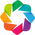

BokehModel(combine_events=True, render_bundle={'docs_json': {'57beef38-d4cd-4912-885f-d8bce6c0e23a': {'version…

In [33]:
viz = h.visualize()

## Exploring results
(Including a static screen shot because the dynamic visualization will not render if the notebook isn't running. i.e. when viewed on GitHub)

![](./visualize_capture.png)

Perhaps if you squint you can see two clusters in the visualization.
Keep in mind of course, the results are found using only the built in models that are meant to act as guides to get you started.
The next step in the process is to start to develop your own models using the infrastructure that Hyrax provides.
The goal is to allow you to focus on science and experimentation instead of spending valuable time writing repetitive, boilerplate code.

## Reach out to us
If you're running into trouble, we want to hear about it! 
* Open an issue: https://github.com/lincc-frameworks/hyrax/issues
* Contact us on Slack:
  * Discovery Alliance [#lincc-frameworks-hyrax](https://discovery-alliance.slack.com/archives/C06HKMZSWPM)
  * DiRAC Institute [#hyrax-at-dirac](https://uw-dirac.slack.com/archives/C08F5FLEY5A)
  * University of Washington, Astronomy Department [#sl-challenge-with-hyrax](https://uw-astronomy.slack.com/archives/C09ANN19WCE)